# Import des données

In [56]:
import pandas as pd
import numpy as np

In [57]:
df = pd.read_csv('concrete_data.csv')
df

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


# Preprocessing

In [58]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

X = df.copy()
y = X.pop('Strength')

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"),
    StandardScaler(),
)

preprocessor = make_column_transformer(
    (transformer_num, make_column_selector(dtype_include=np.number))
)

X = preprocessor.fit_transform(X)
y = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Model

In [59]:
from tensorflow import keras
from tensorflow.keras import layers

input_shape = [X.shape[1]]

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)

C:\Users\ryanh\anaconda3\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=200,
    callbacks=[early_stopping], 
    verbose=0,
)

# Évaluation du model

Minimum validation MAE: 0.14502055943012238


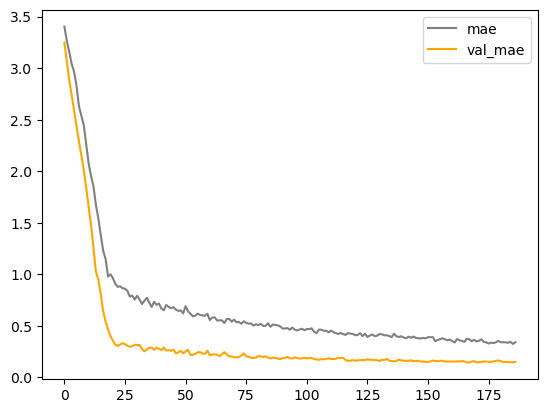

In [61]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['mae', 'val_mae']].plot(color=['gray','orange']);
print("Minimum validation MAE: {}".format(history_df['val_mae'].min()))

In [62]:
scores = model.evaluate(X_test, y_test, verbose = 0)

print('Mean Absolute Error : ', scores[1])

Mean Absolute Error :  0.14599668979644775


In [63]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test, verbose = 0)

print('r2 score: ', r2_score(y_test, y_pred))

r2 score:  0.8818904511173769


Données predites par rapport aux données réelles


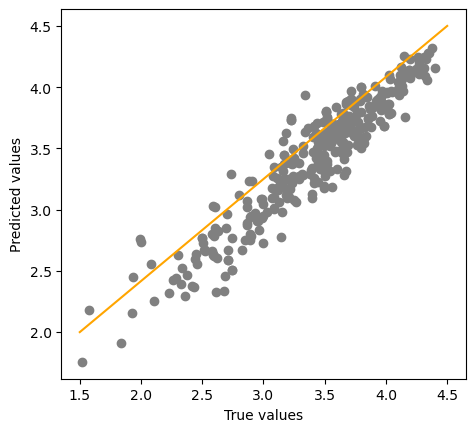

In [64]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred, color='gray')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.plot([1.5, 4.5], [2, 4.5], color='orange')
print('Données predites par rapport aux données réelles')